In [1]:
!pip install -q decoupler
!pip install -q  mofax
!pip install -q muon
!pip install -q  omnipath
!pip install -q --upgrade liana

In [1]:
import pandas as pd
import scanpy as sc
import plotnine as p9
import decoupler as dc
import liana as li

from mudata import MuData

In [2]:
import numpy as np
import pandas as pd

import scanpy as sc

import plotnine as p9

import liana as li

# load muon and mofax
import muon as mu
import mofax as mofa

import decoupler as dc
import anndata as ad

# Spatial data

In [3]:
adata = sc.read("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [4]:
adata.obsm["spatial"] = adata.obsm["X_spatial"]

In [5]:
li.ut.spatial_neighbors(adata, bandwidth=200, cutoff=0.1, kernel='gaussian', set_diag=True)


In [6]:
adata.var.index = adata.var["feature_name"].tolist()

In [7]:
li.mt.lr_bivar(adata,
               function_name='cosine', # Name of the function
               n_perms=100, # Number of permutations to calculate a p-value
               mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
               add_categories=True, # Whether to add local categories to the results
               expr_prop=0.2, # Minimum expr. proportion for ligands/receptors and their subunits
               use_raw=False,
               )

In [8]:
lrdata = adata.obsm['local_scores']


In [9]:
!pip install -q kneed

In [21]:
%matplotlib inline
li.multi.nmf(lrdata, n_components=None, inplace=True, random_state=0, max_iter=200, verbose=True)

  0%|                                                                                | 0/9 [00:00<?, ?it/s]/home/tjzhang01/miniconda3/envs/GraphComm/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
/home/tjzhang01/miniconda3/envs/GraphComm/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
100%|████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.42it/s]

Estimated rank: 3



/home/tjzhang01/miniconda3/envs/GraphComm/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.


In [12]:
lr_loadings = li.ut.get_variable_loadings(lrdata, varm_key='NMF_H').set_index('index')

In [14]:
lr_loadings

,Factor1,Factor2,Factor3
index,,,
COL1A2^CD36,2.445788,0.411481,0.766305
COL1A1^CD36,2.405277,0.391615,0.754488
THBS4^CD36,2.357820,0.121361,0.563206
TIMP1^CD63,2.347343,0.816409,0.604093
CD99^CD81,2.340379,0.634499,0.563854
...,...,...,...
LPL^CD44,0.730424,0.216925,0.177333
TFPI^SDC4,0.715785,0.201680,0.199475
TGFB1^CXCR4,0.657074,0.476590,0.132923


In [15]:
factor_scores = li.ut.get_factor_scores(lrdata, obsm_key='NMF_W')


In [16]:
nmf = sc.AnnData(X=lrdata.obsm['NMF_W'],
                 obs=lrdata.obs,
                 var=pd.DataFrame(index=lr_loadings.columns),
                 uns=lrdata.uns,
                 obsm=lrdata.obsm)

In [17]:
nmf.X = (nmf.X-np.min(nmf.X))/(np.max(nmf.X)-np.min(nmf.X))

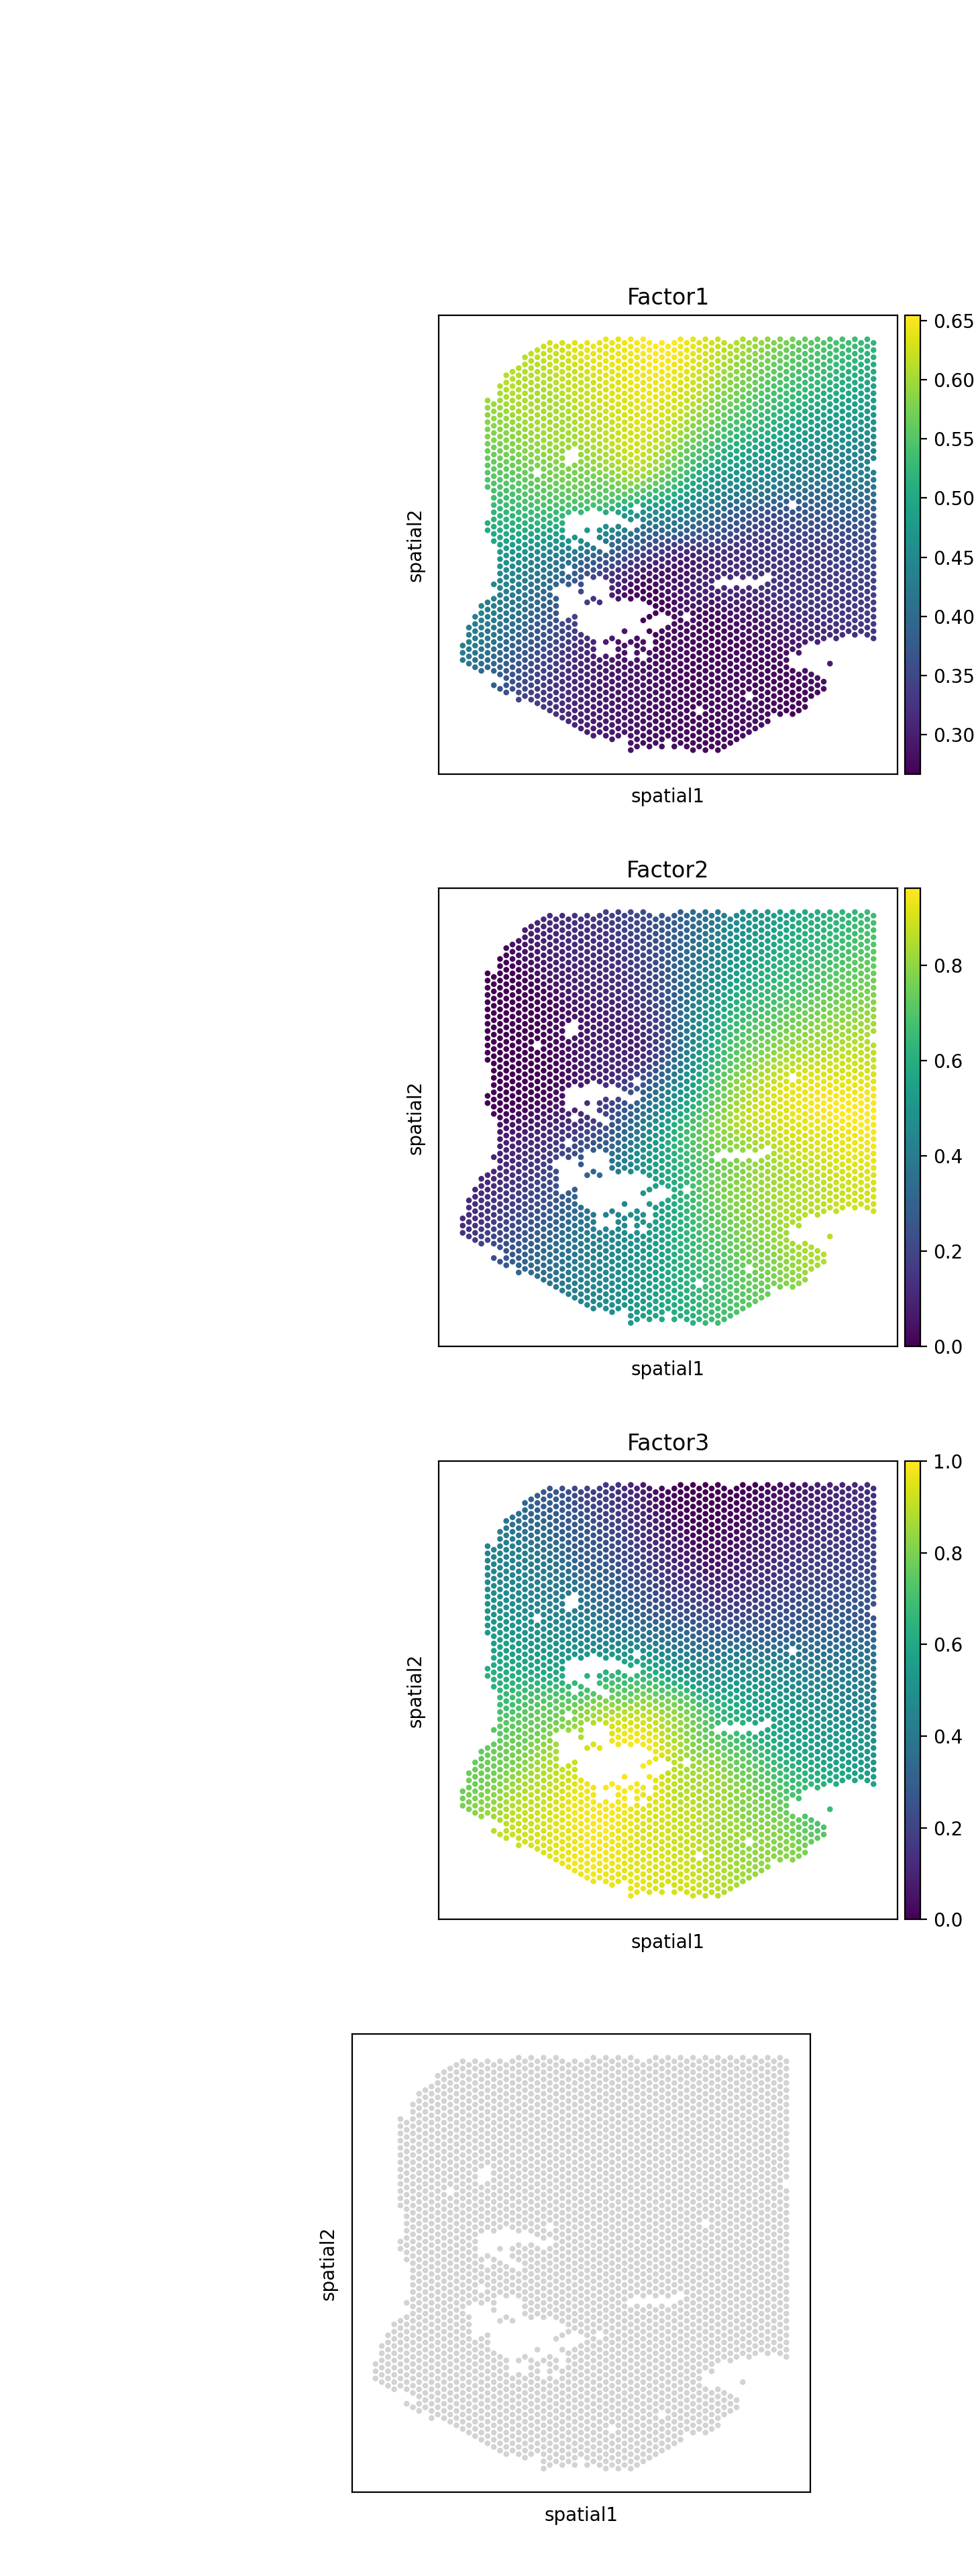

In [18]:
%matplotlib inline
sc.pl.spatial(nmf, color=[*nmf.var.index, None], size=1.4, ncols=1,spot_size=0.01)
#plt.ticklabel_format(

In [19]:
lr_loadings.sort_values("Factor1", ascending=False).head(10)

,Factor1,Factor2,Factor3
index,,,
COL1A2^CD36,2.445788,0.411481,0.766305
COL1A1^CD36,2.405277,0.391615,0.754488
THBS4^CD36,2.357820,0.121361,0.563206
TIMP1^CD63,2.347343,0.816409,0.604093
CD99^CD81,2.340379,0.634499,0.563854
S100A1^RYR2,2.314611,0.000000,0.360932
LUM^ITGB1,2.288653,0.552693,0.581977
LGALS1^ITGB1,2.276205,0.571362,0.578207
CCN2^LRP1,2.261962,0.800086,0.521008


In [20]:
lrdata.uns['global_res'].sort_values("global_mean", ascending=False)

,interaction,ligand,ligand_means,ligand_props,receptor,receptor_means,receptor_props,global_mean,global_sd
1997,TIMP1^CD63,TIMP1,1.771804,0.743548,CD63,2.163210,0.873871,0.789364,0.041411
643,COL1A2^CD36,COL1A2,2.695552,0.973871,CD36,1.502466,0.652258,0.758613,0.027085
73,CCN2^LRP1,CCN2,2.494080,0.935806,LRP1,1.334353,0.594516,0.749141,0.046228
88,PSAP^LRP1,PSAP,2.662350,0.977419,LRP1,1.334353,0.594516,0.745788,0.045749
642,COL1A1^CD36,COL1A1,2.501117,0.935161,CD36,1.502466,0.652258,0.743384,0.028469
...,...,...,...,...,...,...,...,...,...
271,COMP^ITGA5,COMP,0.477391,0.227742,ITGA5,0.570701,0.281290,0.248684,0.058620
55,LPL^CD44,LPL,1.123527,0.499677,CD44,0.463828,0.218387,0.234938,0.013875
250,TFPI^SDC4,TFPI,0.607733,0.289677,SDC4,0.403991,0.202581,0.233961,0.009566
1663,TGFB1^LPP,TGFB1,0.505123,0.244839,LPP,0.419039,0.207742,0.224760,0.017317
